# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students_cleaned.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [ ]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label


In [ ]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
      ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...


<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'mask_fill_value' is no

WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


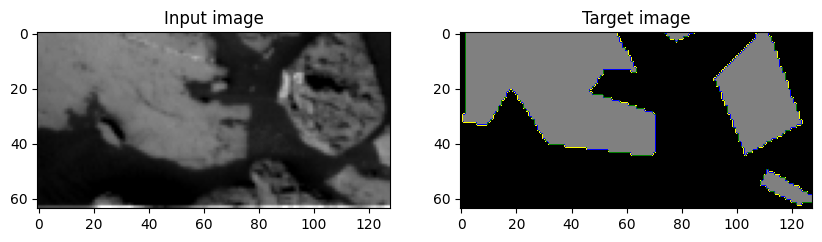

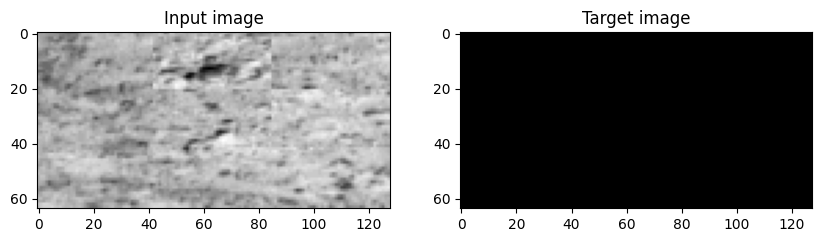

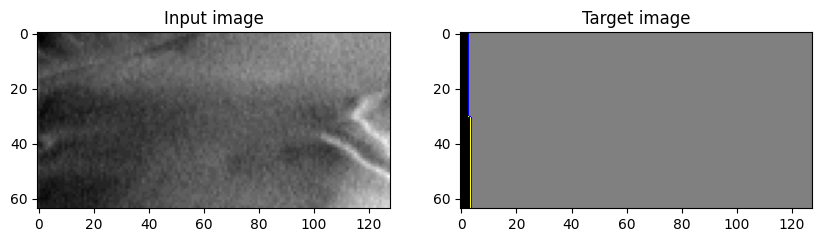

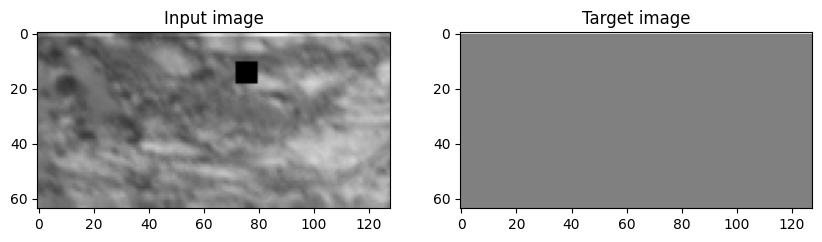

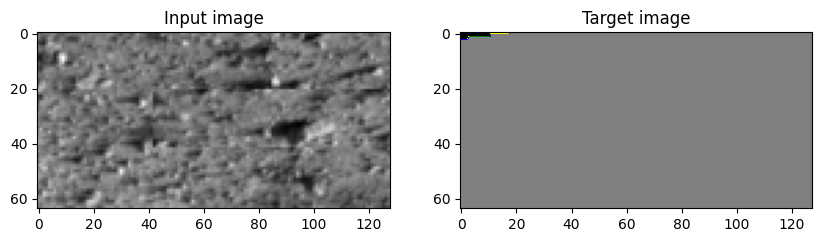

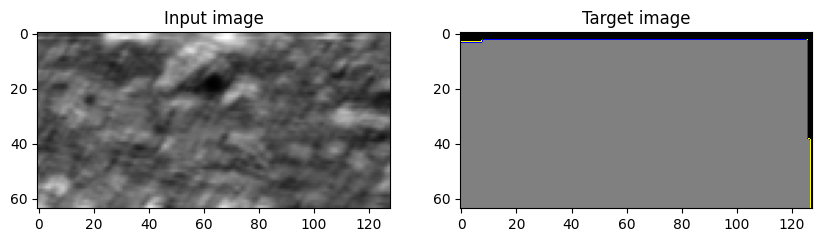

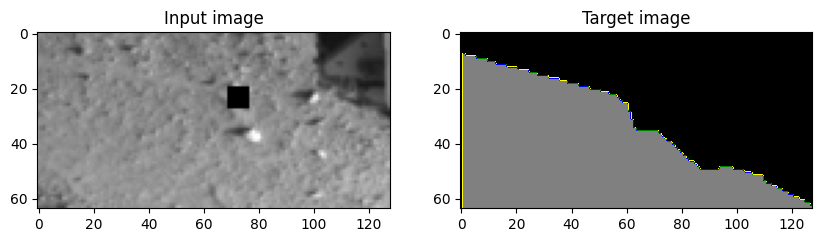

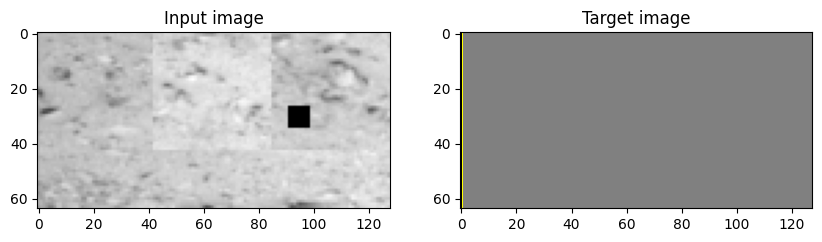

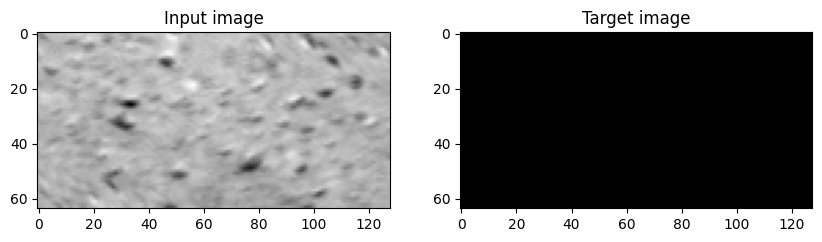

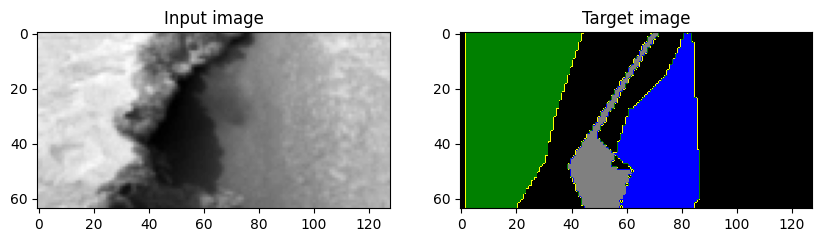

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [ ]:
def aspp_block(x, filter_size, number_filters):
    """
    Atrous spatial pyramid pooling (ASPP)
    """
    y1 = tfkl.Conv2D(number_filters, (1, 1), kernel_initializer='lecun_uniform', padding='same', activation='relu', use_bias=False)(x)
    y2 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=6, padding='same', activation='relu', use_bias=False)(x)
    y3 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=12, padding='same', activation='relu', use_bias=False)(x)
    y4 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=18, padding='same', activation='relu', use_bias=False)(x)

    # Global Average Pooling
    # global_avg_pool = tfkl.GlobalAveragePooling2D()(x)
    # global_avg_pool = tfkl.Reshape((1, 1, tf.shape(global_avg_pool)[-1]))(global_avg_pool)
    # global_avg_pool = tfkl.Conv2D(number_filters, kernel_size=1, activation='relu', padding='same')(global_avg_pool)
    # global_avg_pool = tfkl.UpSampling2D(size=(tf.shape(x)[1], tf.shape(x)[2]), interpolation='bilinear')(global_avg_pool)

    concat = tfkl.Concatenate()([y1, y2, y3, y4])
    concat = tfkl.Conv2D(number_filters, (1, 1), padding='same', activation='relu')(concat)
    return concat

In [ ]:
def Attention_ResUNet_with_aspp(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # downsample the input to match every downsampling made
    x_64 = tfkl.AveragePooling2D(pool_size=(2,2))(inputs)
    x_32 = tfkl.AveragePooling2D(pool_size=(4,4))(inputs)
    x_16 = tfkl.AveragePooling2D(pool_size=(8,8))(inputs)
    x_8 = tfkl.AveragePooling2D(pool_size=(16,16))(inputs)

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    conc_64 = tfkl.concatenate([pool_64, x_64], axis=axis)
    # DownRes 2
    conv_64 = res_conv_block(conc_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    conc_32 = tfkl.concatenate([pool_32, x_32], axis=axis)
    # DownRes 3
    conv_32 = res_conv_block(conc_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    conc_16 = tfkl.concatenate([pool_16, x_16], axis=axis)
    # DownRes 4
    conv_16 = res_conv_block(conc_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    conc_8 = tfkl.concatenate([pool_8, x_8], axis=axis)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(conc_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    aspp = aspp_block(conv_8, FILTER_SIZE, 16*FILTER_NUM)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(aspp)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    up_out = tfkl.UpSampling2D(size=(UP_SAMP_SIZE**(3), UP_SAMP_SIZE**(3)), data_format="channels_last")(up_conv_16)
    supervision_1 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_1')(up_out)

    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    up_out_2 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE**(2), UP_SAMP_SIZE**(2)), data_format="channels_last")(up_conv_32)
    supervision_2 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_2')(up_out_2)

    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    up_out_3 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    supervision_3 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_3')(up_out_3)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('softmax')(conv_final)

    # Model integration
    model = tfk.models.Model(inputs, outputs = [conv_final, supervision_3, supervision_2, supervision_1], name="AttentionResUNet_with_aspp_and_deep_supervision")
    return model


In [ ]:
model = Attention_ResUNet_with_aspp()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


Model: "AttentionResUNet_with_aspp_and_deep_supervision"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 64)  │          128 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 64)  │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ average_pooling2d      │ (None, 32, 64, 1)    │            0 │ input_layer[0][0]   │    -    │
│ (AveragePooling2D)     │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, 32, 64, 65)   │            0 │ max_pooling2d[0][0… │    -    │
│ (Concatenate)          │                      │              │ average_pooling2d[… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 128)  │       75,008 │ concatenate[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3

 Total params: 72,668,524 (277.21 MB)

 Trainable params: 72,647,010 (277.13 MB)

 Non-trainable params: 21,514 (84.04 KB)

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            plt.close()

In [ ]:
initial_learning_rate = 0.1
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/500)
steps_per_epoch = int(X_train.shape[0]/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    # Cross entropy loss
    cross_entropy_loss = -y_true * tf.math.log(y_pred)

    # Focal loss component
    focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy_loss
    return tf.reduce_sum(focal_loss, axis=-1)

# Dice Loss function
def dice_loss(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = 1 - (2.0 * intersection + epsilon) / (union + epsilon)
    return tf.reduce_mean(dice)

# Combined Loss function
def combined_loss(y_true, y_pred, alpha=0.25, gamma=2.0, epsilon=1e-6):
    focal = focal_loss(y_true, y_pred, alpha, gamma)
    dice = dice_loss(y_true, y_pred, epsilon)
    return tf.reduce_mean(focal + dice)


@tf.function
def deep_supervision_loss(y_true, outputs, weights = [0.4, 0.3, 0.2, 0.1]):
    """
    Combine the final output loss and intermediate losses with weights.
    Args:
        y_true: Ground truth labels.
        outputs: List of outputs from model [final_output, supervision_1, supervision_2].
        weights: List of weights for each output.
    Returns:
        Combined loss.
    """

    losses = []

    for i in range(len(weights)):
        pred = outputs[i]
        # y_resized = tf.image.resize(y_true, [*pred.shape[0:2]])

        losses.append(weights[i] * combined_loss(y_true, pred))



    return tf.reduce_sum(losses)

print("Compiling model...")
model.compile(
    #loss=lambda y_true, y_pred: deep_supervision_loss(y_true, y_pred),
    #loss=combined_loss,
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        ],
    loss_weights=[1, 0.3, 0.2, 0.15],
    optimizer=tf.keras.optimizers.AdamW(lr_schedule),
    metrics=[ MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]), "accuracy", "accuracy", "accuracy"]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_activation_30_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_activation_30_mean_iou",
    factor=0.5,
    patience=30
)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - activation_30_mean_iou: 0.0856 - loss: 1.5279

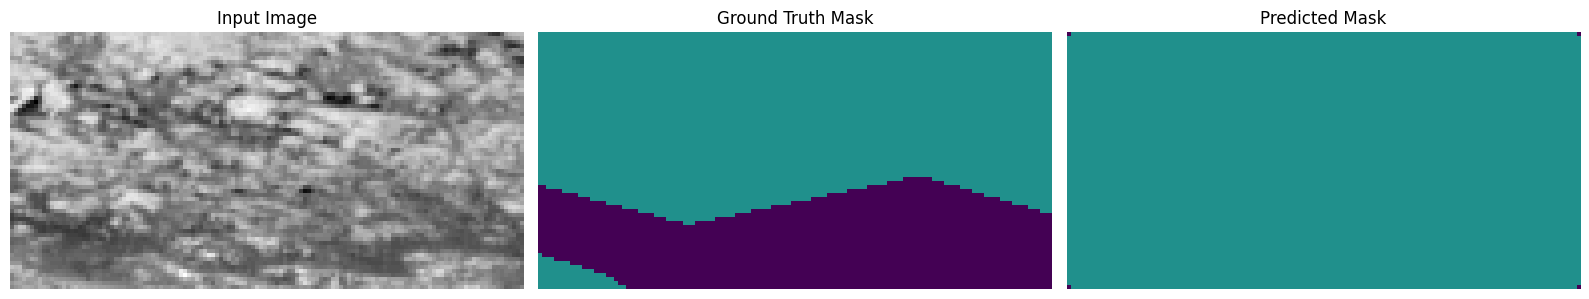

30/30 ━━━━━━━━━━━━━━━━━━━━ 765s 13s/step - activation_30_mean_iou: 0.0856 - loss: 1.5244 - val_activation_30_mean_iou: 0.0641 - val_loss: 914528.9375
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - activation_30_mean_iou: 0.0978 - loss: 1.3325 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 1967.8694
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.1662 - loss: 1.2216 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 80.1709
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.1957 - loss: 1.2199 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 176.0918
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.2310 - loss: 1.1383 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 23.4029
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.2487 - loss: 1.1511

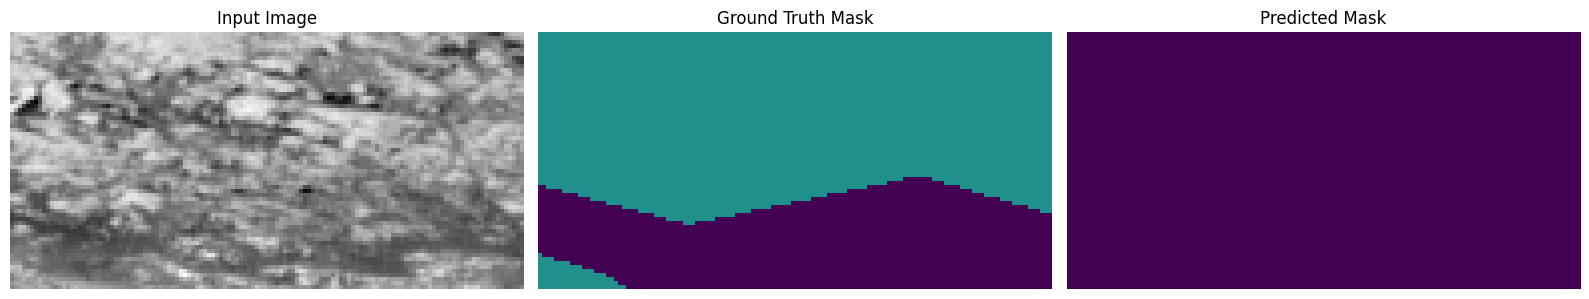

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.2491 - loss: 1.1499 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 10.0152
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.2485 - loss: 1.1351 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 5.1388
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.2650 - loss: 1.0900 - val_activation_30_mean_iou: 0.0524 - val_loss: 3.4767
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.2836 - loss: 1.0541 - val_activation_30_mean_iou: 0.0000e+00 - val_loss: 4.9514
Epoch 10/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.2878 - loss: 1.0355 - val_activation_30_mean_iou: 0.0923 - val_loss: 2.0910
Epoch 11/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.2861 - loss: 1.0614

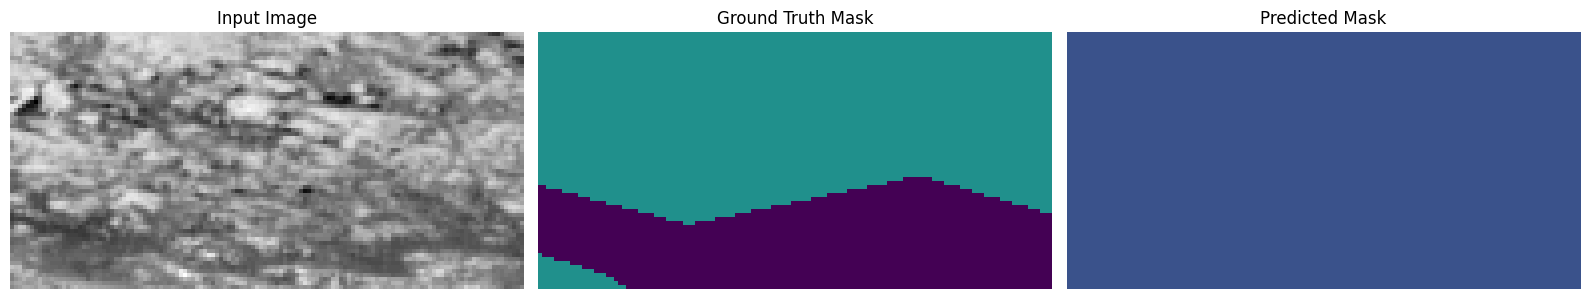

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.2866 - loss: 1.0598 - val_activation_30_mean_iou: 0.0890 - val_loss: 2.7148
Epoch 12/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.2991 - loss: 1.0089 - val_activation_30_mean_iou: 0.0877 - val_loss: 2.5629
Epoch 13/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3014 - loss: 1.0106 - val_activation_30_mean_iou: 0.0961 - val_loss: 1.9478
Epoch 14/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3149 - loss: 0.9723 - val_activation_30_mean_iou: 0.1038 - val_loss: 2.3235
Epoch 15/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3017 - loss: 1.0002 - val_activation_30_mean_iou: 0.0934 - val_loss: 2.4159
Epoch 16/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3226 - loss: 0.9842

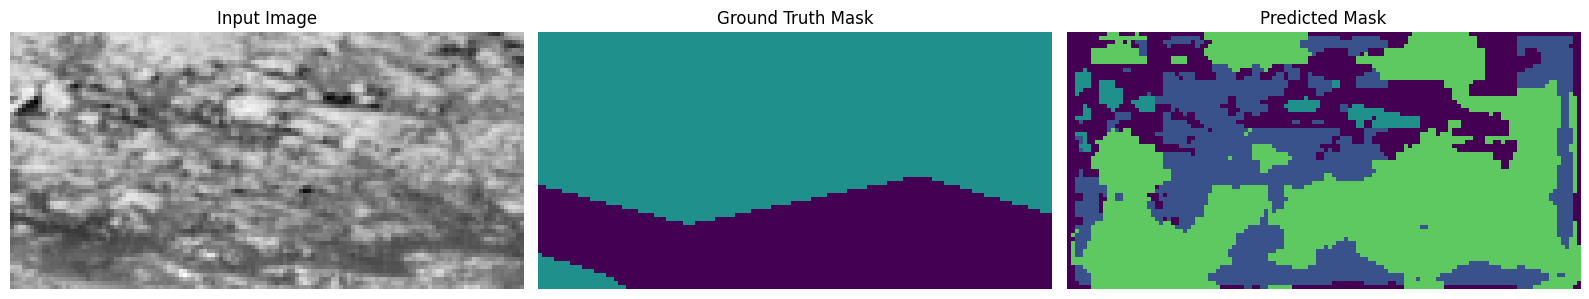

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3229 - loss: 0.9830 - val_activation_30_mean_iou: 0.2000 - val_loss: 1.2337
Epoch 17/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.3223 - loss: 0.9686 - val_activation_30_mean_iou: 0.1088 - val_loss: 2.4330
Epoch 18/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3227 - loss: 0.9350 - val_activation_30_mean_iou: 0.1573 - val_loss: 1.8739
Epoch 19/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3265 - loss: 0.9666 - val_activation_30_mean_iou: 0.1198 - val_loss: 2.3988
Epoch 20/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.3266 - loss: 0.9397 - val_activation_30_mean_iou: 0.1209 - val_loss: 2.2132
Epoch 21/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3348 - loss: 0.9282

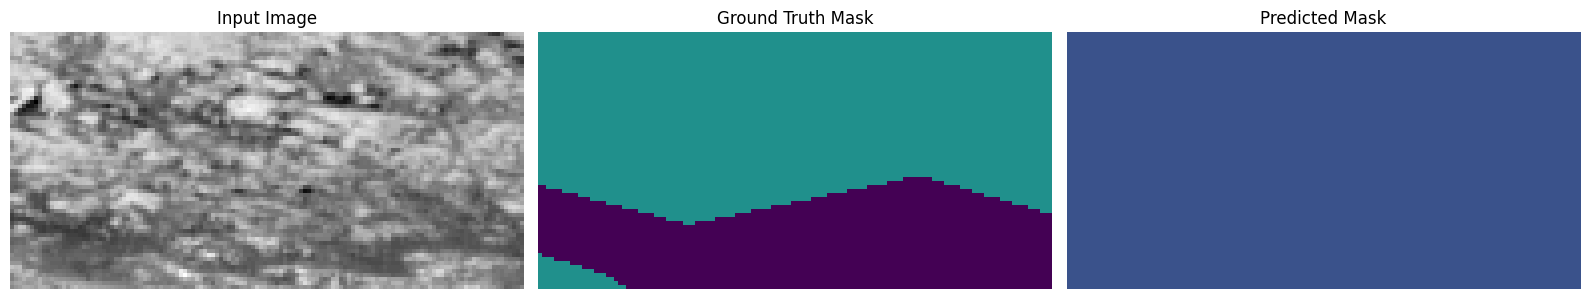

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3351 - loss: 0.9271 - val_activation_30_mean_iou: 0.1021 - val_loss: 2.3182
Epoch 22/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3450 - loss: 0.9135 - val_activation_30_mean_iou: 0.0866 - val_loss: 2.3531
Epoch 23/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3469 - loss: 0.8990 - val_activation_30_mean_iou: 0.0876 - val_loss: 3.4474
Epoch 24/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.3479 - loss: 0.9037 - val_activation_30_mean_iou: 0.0939 - val_loss: 2.7234
Epoch 25/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3545 - loss: 0.8914 - val_activation_30_mean_iou: 0.1505 - val_loss: 1.3868
Epoch 26/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3498 - loss: 0.8872

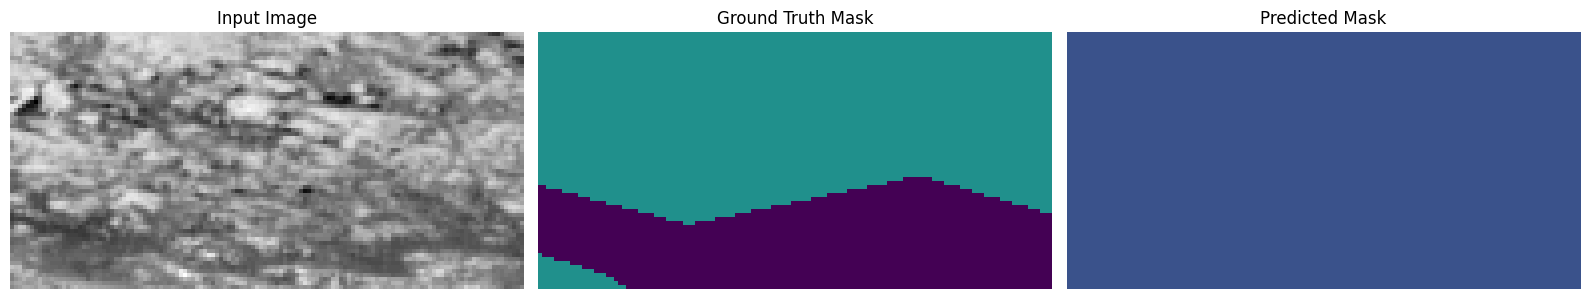

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3498 - loss: 0.8867 - val_activation_30_mean_iou: 0.1135 - val_loss: 1.9385
Epoch 27/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3536 - loss: 0.8809 - val_activation_30_mean_iou: 0.0883 - val_loss: 3.0023
Epoch 28/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3487 - loss: 0.8994 - val_activation_30_mean_iou: 0.2455 - val_loss: 1.1248
Epoch 29/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3646 - loss: 0.8665 - val_activation_30_mean_iou: 0.2587 - val_loss: 1.0797
Epoch 30/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3576 - loss: 0.8691 - val_activation_30_mean_iou: 0.1387 - val_loss: 1.6680
Epoch 31/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3783 - loss: 0.8504

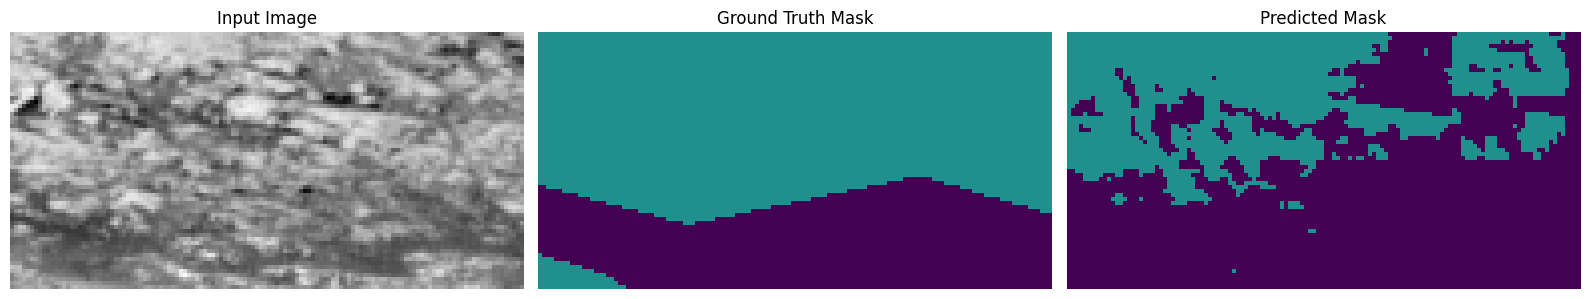

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3783 - loss: 0.8499 - val_activation_30_mean_iou: 0.1256 - val_loss: 1.4362
Epoch 32/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3663 - loss: 0.8453 - val_activation_30_mean_iou: 0.2934 - val_loss: 0.9312
Epoch 33/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3514 - loss: 0.8796 - val_activation_30_mean_iou: 0.2807 - val_loss: 1.0748
Epoch 34/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3726 - loss: 0.8367 - val_activation_30_mean_iou: 0.0533 - val_loss: 2.3701
Epoch 35/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3656 - loss: 0.8629 - val_activation_30_mean_iou: 0.3045 - val_loss: 1.0687
Epoch 36/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3536 - loss: 0.8856

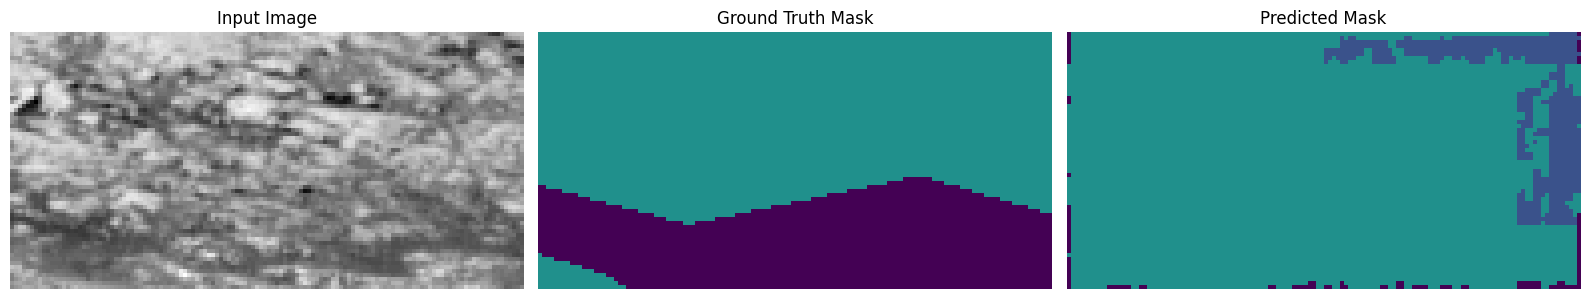

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3541 - loss: 0.8842 - val_activation_30_mean_iou: 0.3116 - val_loss: 0.9525
Epoch 37/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3787 - loss: 0.8212 - val_activation_30_mean_iou: 0.2814 - val_loss: 1.1800
Epoch 38/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3853 - loss: 0.8168 - val_activation_30_mean_iou: 0.3194 - val_loss: 1.0250
Epoch 39/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.3735 - loss: 0.8290 - val_activation_30_mean_iou: 0.2041 - val_loss: 1.3240
Epoch 40/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3752 - loss: 0.8337 - val_activation_30_mean_iou: 0.1742 - val_loss: 1.3287
Epoch 41/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3764 - loss: 0.8395

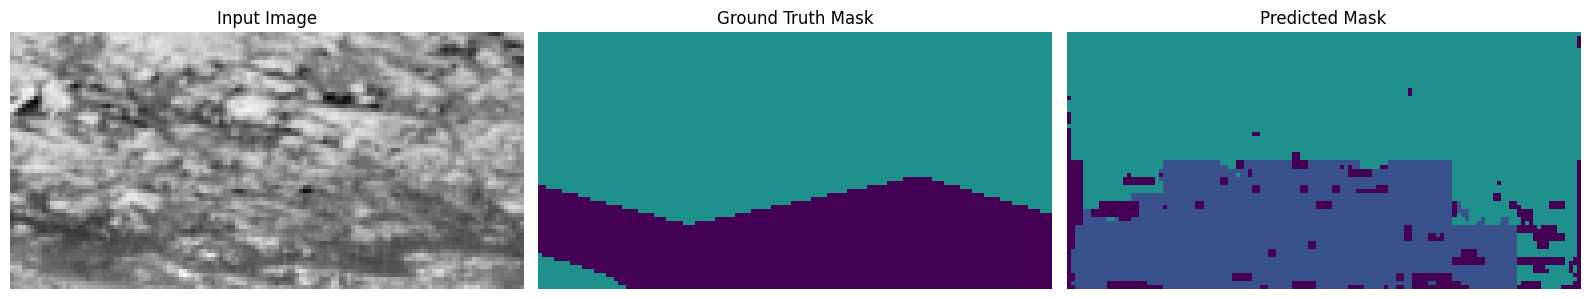

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3771 - loss: 0.8381 - val_activation_30_mean_iou: 0.2394 - val_loss: 1.1455
Epoch 42/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.3736 - loss: 0.8414 - val_activation_30_mean_iou: 0.3042 - val_loss: 0.9391
Epoch 43/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3818 - loss: 0.8265 - val_activation_30_mean_iou: 0.3134 - val_loss: 0.8430
Epoch 44/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.3853 - loss: 0.8129 - val_activation_30_mean_iou: 0.2674 - val_loss: 1.0151
Epoch 45/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.3839 - loss: 0.8206 - val_activation_30_mean_iou: 0.3360 - val_loss: 0.8428
Epoch 46/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3868 - loss: 0.7979

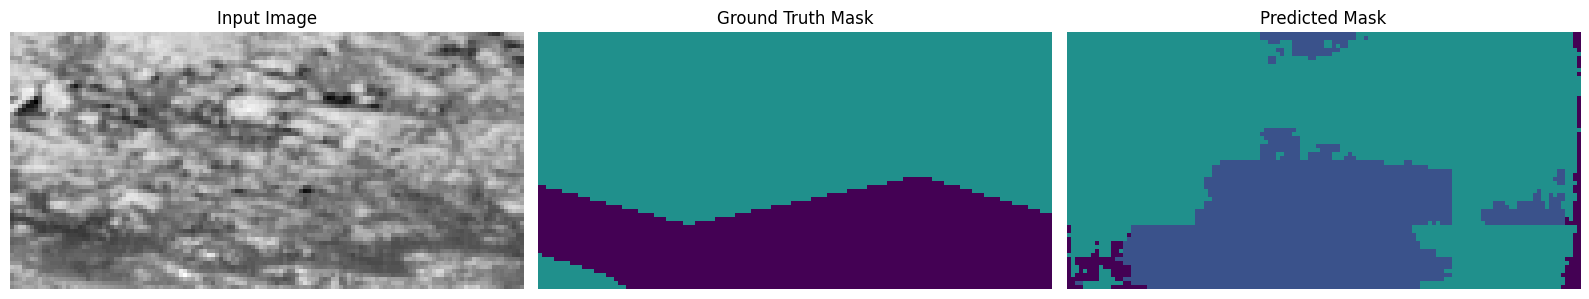

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.3873 - loss: 0.7968 - val_activation_30_mean_iou: 0.2883 - val_loss: 0.9384
Epoch 47/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3927 - loss: 0.7852 - val_activation_30_mean_iou: 0.0773 - val_loss: 1.9762
Epoch 48/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3843 - loss: 0.7992 - val_activation_30_mean_iou: 0.3634 - val_loss: 0.8298
Epoch 49/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3912 - loss: 0.8156 - val_activation_30_mean_iou: 0.2765 - val_loss: 0.9485
Epoch 50/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3962 - loss: 0.7839 - val_activation_30_mean_iou: 0.2767 - val_loss: 1.0169
Epoch 51/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.3879 - loss: 0.8119

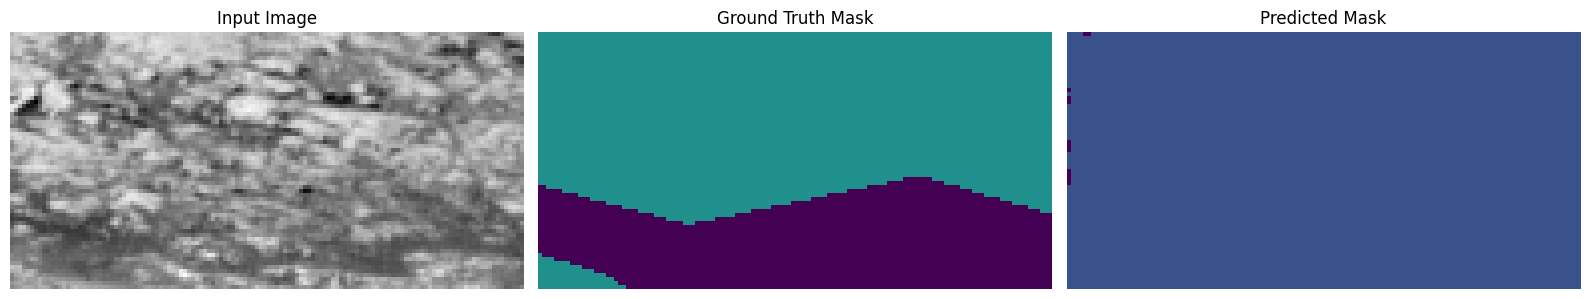

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.3886 - loss: 0.8105 - val_activation_30_mean_iou: 0.3161 - val_loss: 1.0654
Epoch 52/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4022 - loss: 0.7813 - val_activation_30_mean_iou: 0.3647 - val_loss: 0.9282
Epoch 53/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4049 - loss: 0.7673 - val_activation_30_mean_iou: 0.4319 - val_loss: 0.7479
Epoch 54/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4025 - loss: 0.7835 - val_activation_30_mean_iou: 0.4182 - val_loss: 0.8233
Epoch 55/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4004 - loss: 0.7707 - val_activation_30_mean_iou: 0.3502 - val_loss: 1.0134
Epoch 56/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4058 - loss: 0.7499

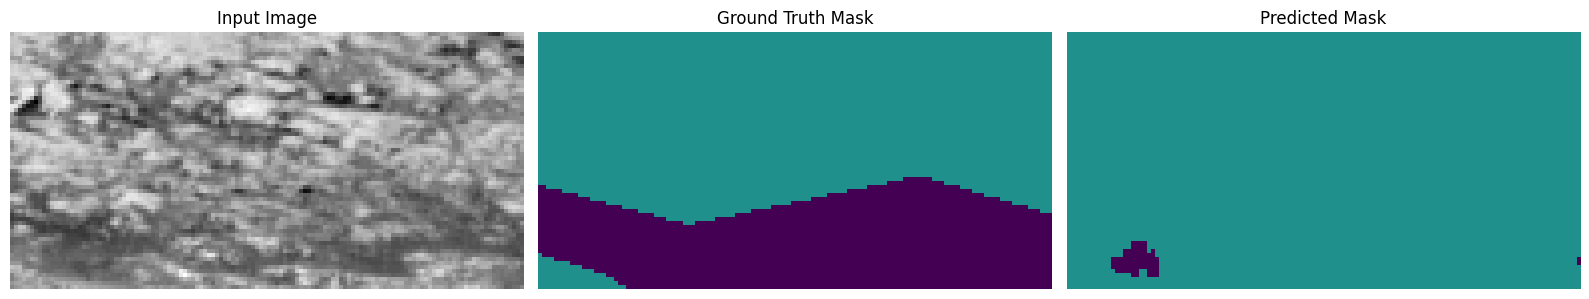

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4060 - loss: 0.7495 - val_activation_30_mean_iou: 0.1341 - val_loss: 1.9547
Epoch 57/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4025 - loss: 0.7714 - val_activation_30_mean_iou: 0.3329 - val_loss: 0.9330
Epoch 58/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4055 - loss: 0.7777 - val_activation_30_mean_iou: 0.3760 - val_loss: 0.8098
Epoch 59/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4119 - loss: 0.7715 - val_activation_30_mean_iou: 0.3870 - val_loss: 0.8664
Epoch 60/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4151 - loss: 0.7545 - val_activation_30_mean_iou: 0.4204 - val_loss: 0.7864
Epoch 61/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4275 - loss: 0.7261

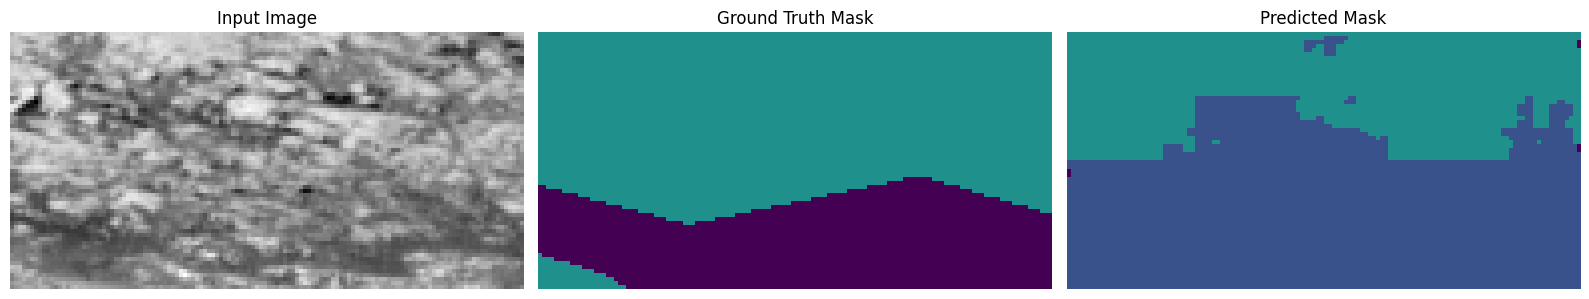

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4277 - loss: 0.7255 - val_activation_30_mean_iou: 0.2888 - val_loss: 0.9931
Epoch 62/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4068 - loss: 0.7415 - val_activation_30_mean_iou: 0.3258 - val_loss: 1.1342
Epoch 63/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4248 - loss: 0.7149 - val_activation_30_mean_iou: 0.2583 - val_loss: 1.0341
Epoch 64/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4120 - loss: 0.7394 - val_activation_30_mean_iou: 0.2899 - val_loss: 1.0169
Epoch 65/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4240 - loss: 0.7234 - val_activation_30_mean_iou: 0.3463 - val_loss: 0.9166
Epoch 66/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4112 - loss: 0.7413

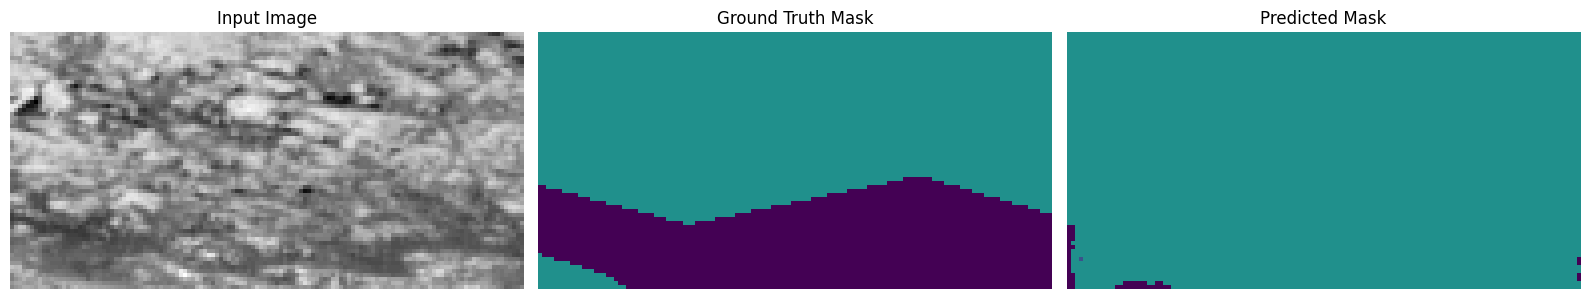

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4118 - loss: 0.7400 - val_activation_30_mean_iou: 0.4281 - val_loss: 0.6968
Epoch 67/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4184 - loss: 0.7228 - val_activation_30_mean_iou: 0.4007 - val_loss: 0.7303
Epoch 68/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4113 - loss: 0.7409 - val_activation_30_mean_iou: 0.2168 - val_loss: 1.8739
Epoch 69/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4235 - loss: 0.7292 - val_activation_30_mean_iou: 0.4243 - val_loss: 0.7273
Epoch 70/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4265 - loss: 0.7045 - val_activation_30_mean_iou: 0.3773 - val_loss: 0.7953
Epoch 71/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4292 - loss: 0.7155

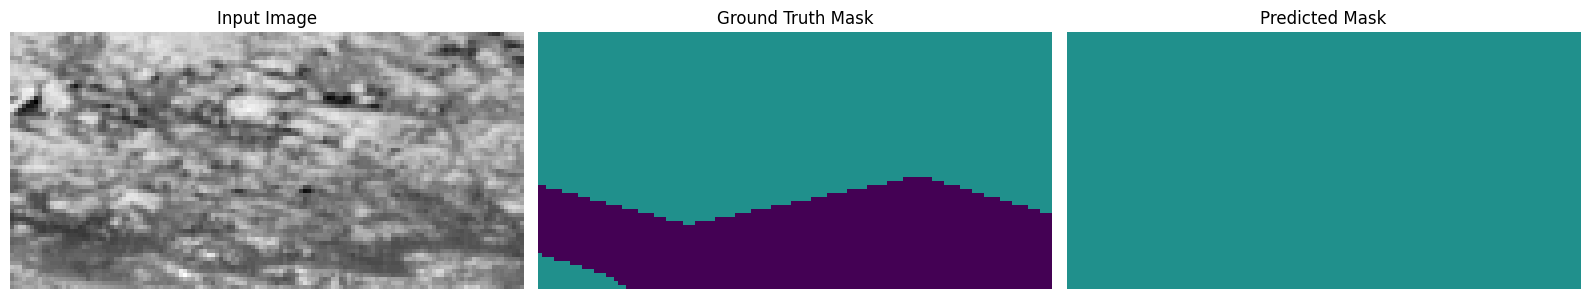

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4294 - loss: 0.7147 - val_activation_30_mean_iou: 0.3970 - val_loss: 0.7626
Epoch 72/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4277 - loss: 0.7041 - val_activation_30_mean_iou: 0.4082 - val_loss: 0.7372
Epoch 73/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4321 - loss: 0.6855 - val_activation_30_mean_iou: 0.4282 - val_loss: 0.7502
Epoch 74/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4222 - loss: 0.7072 - val_activation_30_mean_iou: 0.3708 - val_loss: 0.9556
Epoch 75/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4355 - loss: 0.6847 - val_activation_30_mean_iou: 0.2810 - val_loss: 0.9803
Epoch 76/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4302 - loss: 0.7046

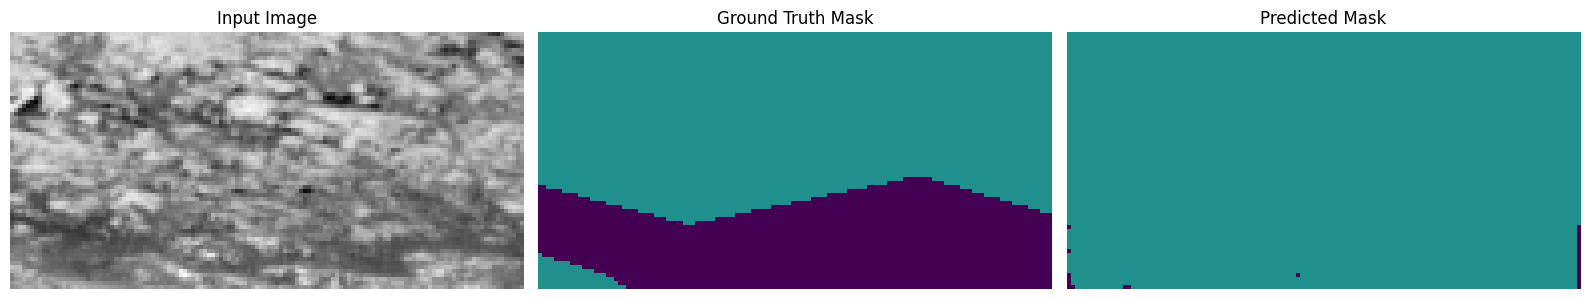

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4305 - loss: 0.7038 - val_activation_30_mean_iou: 0.4509 - val_loss: 0.6495
Epoch 77/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4207 - loss: 0.7044 - val_activation_30_mean_iou: 0.3748 - val_loss: 0.8135
Epoch 78/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4371 - loss: 0.6945 - val_activation_30_mean_iou: 0.4149 - val_loss: 0.7188
Epoch 79/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4217 - loss: 0.7040 - val_activation_30_mean_iou: 0.3488 - val_loss: 0.9117
Epoch 80/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4340 - loss: 0.6986 - val_activation_30_mean_iou: 0.4127 - val_loss: 0.7672
Epoch 81/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4385 - loss: 0.6782

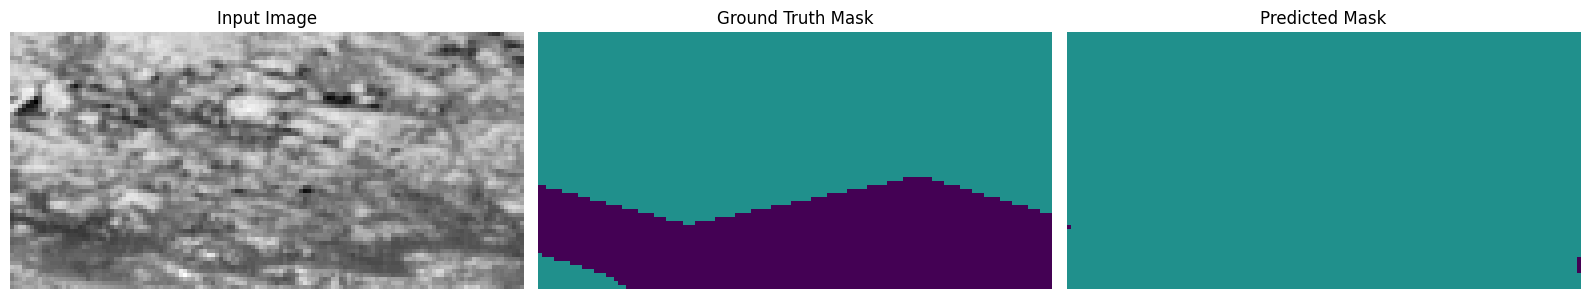

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4387 - loss: 0.6779 - val_activation_30_mean_iou: 0.4120 - val_loss: 0.7611
Epoch 82/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4439 - loss: 0.6710 - val_activation_30_mean_iou: 0.3809 - val_loss: 0.7747
Epoch 83/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4317 - loss: 0.6971 - val_activation_30_mean_iou: 0.3078 - val_loss: 0.9482
Epoch 84/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4383 - loss: 0.6726 - val_activation_30_mean_iou: 0.4259 - val_loss: 0.6706
Epoch 85/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4487 - loss: 0.6642 - val_activation_30_mean_iou: 0.4026 - val_loss: 0.8274
Epoch 86/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4507 - loss: 0.6515

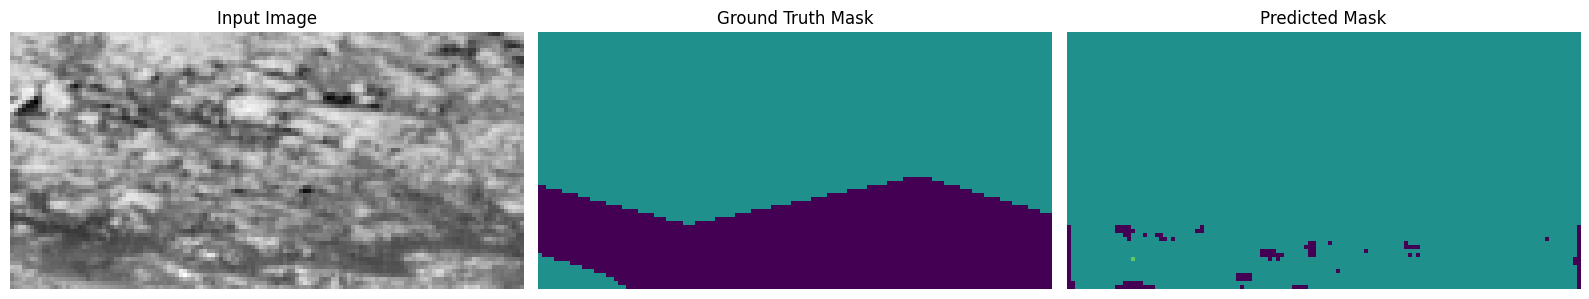

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4507 - loss: 0.6512 - val_activation_30_mean_iou: 0.4327 - val_loss: 0.7148
Epoch 87/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4483 - loss: 0.6443 - val_activation_30_mean_iou: 0.3840 - val_loss: 0.7791
Epoch 88/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4405 - loss: 0.6593 - val_activation_30_mean_iou: 0.3947 - val_loss: 0.7228
Epoch 89/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4473 - loss: 0.6558 - val_activation_30_mean_iou: 0.3874 - val_loss: 0.7667
Epoch 90/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4420 - loss: 0.6565 - val_activation_30_mean_iou: 0.3521 - val_loss: 0.8663
Epoch 91/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4491 - loss: 0.6538

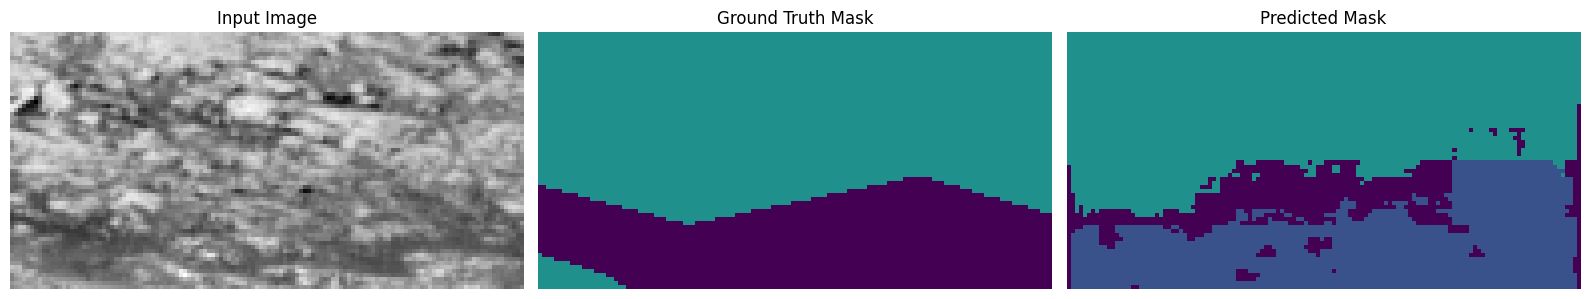

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4492 - loss: 0.6533 - val_activation_30_mean_iou: 0.3925 - val_loss: 0.7819
Epoch 92/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4413 - loss: 0.6616 - val_activation_30_mean_iou: 0.4011 - val_loss: 0.7628
Epoch 93/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4513 - loss: 0.6442 - val_activation_30_mean_iou: 0.4131 - val_loss: 0.7563
Epoch 94/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4578 - loss: 0.6221 - val_activation_30_mean_iou: 0.4330 - val_loss: 0.7207
Epoch 95/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4338 - loss: 0.6686 - val_activation_30_mean_iou: 0.4482 - val_loss: 0.6600
Epoch 96/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4644 - loss: 0.6208

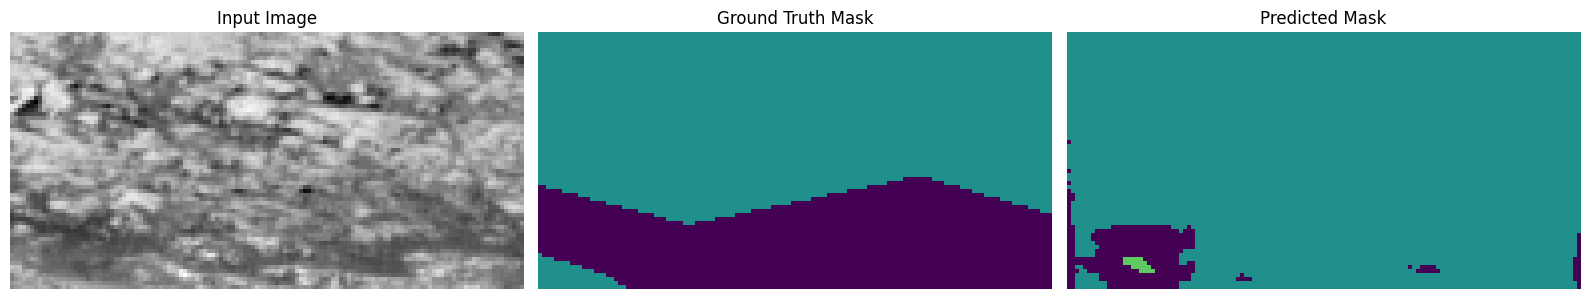

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4644 - loss: 0.6205 - val_activation_30_mean_iou: 0.4049 - val_loss: 0.7496
Epoch 97/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4572 - loss: 0.6312 - val_activation_30_mean_iou: 0.4667 - val_loss: 0.6411
Epoch 98/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4572 - loss: 0.6230 - val_activation_30_mean_iou: 0.4448 - val_loss: 0.6221
Epoch 99/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4588 - loss: 0.6206 - val_activation_30_mean_iou: 0.3498 - val_loss: 0.8646
Epoch 100/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4601 - loss: 0.6264 - val_activation_30_mean_iou: 0.4213 - val_loss: 0.7636
Epoch 101/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4618 - loss: 0.6189

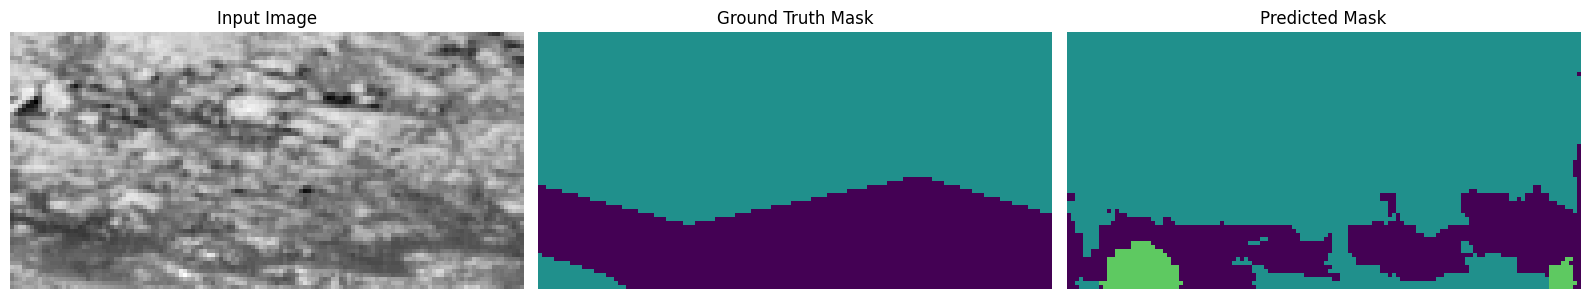

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4619 - loss: 0.6187 - val_activation_30_mean_iou: 0.4133 - val_loss: 0.6898
Epoch 102/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4784 - loss: 0.5858 - val_activation_30_mean_iou: 0.4376 - val_loss: 0.6622
Epoch 103/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4693 - loss: 0.6024 - val_activation_30_mean_iou: 0.4106 - val_loss: 0.7261
Epoch 104/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4584 - loss: 0.6233 - val_activation_30_mean_iou: 0.4226 - val_loss: 0.6955
Epoch 105/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4588 - loss: 0.6098 - val_activation_30_mean_iou: 0.4656 - val_loss: 0.6075
Epoch 106/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4709 - loss: 0.5943

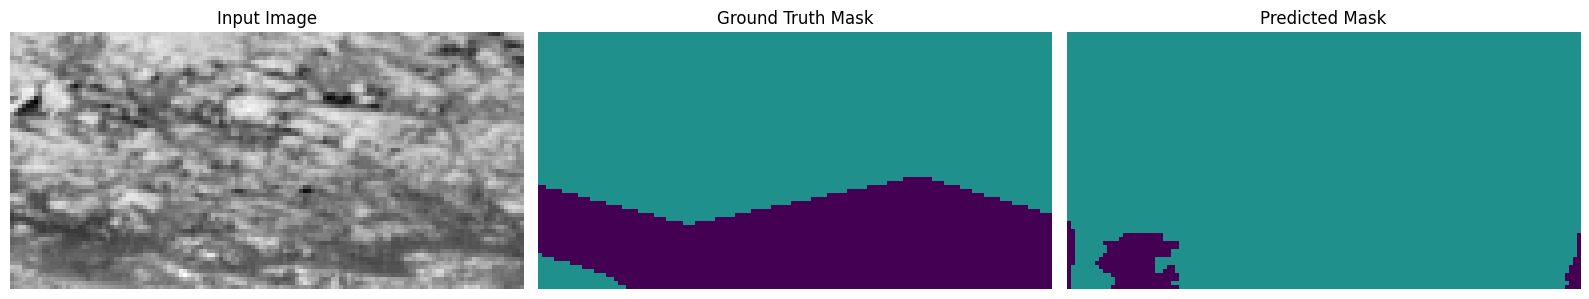

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4710 - loss: 0.5939 - val_activation_30_mean_iou: 0.4575 - val_loss: 0.6115
Epoch 107/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4629 - loss: 0.6118 - val_activation_30_mean_iou: 0.4353 - val_loss: 0.6445
Epoch 108/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4689 - loss: 0.5931 - val_activation_30_mean_iou: 0.4492 - val_loss: 0.5911
Epoch 109/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4649 - loss: 0.5988 - val_activation_30_mean_iou: 0.4503 - val_loss: 0.6255
Epoch 110/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4701 - loss: 0.5912 - val_activation_30_mean_iou: 0.4694 - val_loss: 0.6530
Epoch 111/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4845 - loss: 0.5731

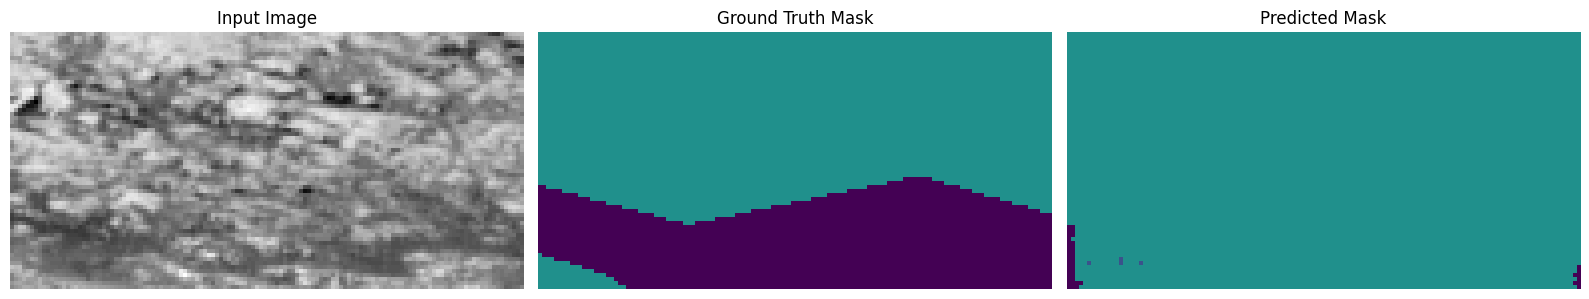

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4844 - loss: 0.5729 - val_activation_30_mean_iou: 0.4720 - val_loss: 0.5761
Epoch 112/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4678 - loss: 0.5946 - val_activation_30_mean_iou: 0.4504 - val_loss: 0.6332
Epoch 113/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4658 - loss: 0.5888 - val_activation_30_mean_iou: 0.3899 - val_loss: 0.8031
Epoch 114/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4777 - loss: 0.5851 - val_activation_30_mean_iou: 0.3742 - val_loss: 0.8479
Epoch 115/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4648 - loss: 0.6061 - val_activation_30_mean_iou: 0.4435 - val_loss: 0.7142
Epoch 116/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4829 - loss: 0.5624

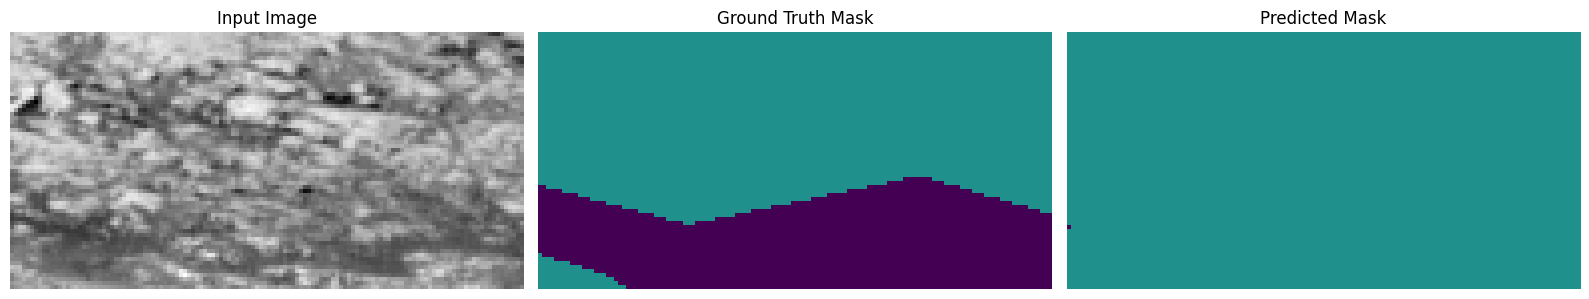

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4829 - loss: 0.5624 - val_activation_30_mean_iou: 0.4298 - val_loss: 0.6594
Epoch 117/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4718 - loss: 0.5785 - val_activation_30_mean_iou: 0.4433 - val_loss: 0.6715
Epoch 118/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4815 - loss: 0.5690 - val_activation_30_mean_iou: 0.4560 - val_loss: 0.6101
Epoch 119/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4813 - loss: 0.5693 - val_activation_30_mean_iou: 0.4788 - val_loss: 0.5830
Epoch 120/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4884 - loss: 0.5538 - val_activation_30_mean_iou: 0.4265 - val_loss: 0.6978
Epoch 121/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4958 - loss: 0.5458

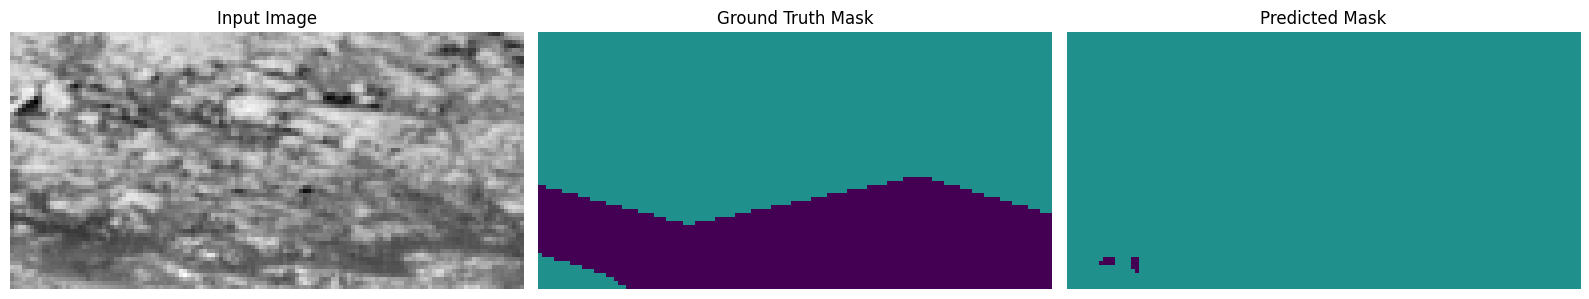

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4954 - loss: 0.5458 - val_activation_30_mean_iou: 0.4327 - val_loss: 0.6259
Epoch 122/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4745 - loss: 0.5608 - val_activation_30_mean_iou: 0.4515 - val_loss: 0.5933
Epoch 123/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4860 - loss: 0.5468 - val_activation_30_mean_iou: 0.3906 - val_loss: 0.7422
Epoch 124/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4875 - loss: 0.5474 - val_activation_30_mean_iou: 0.4297 - val_loss: 0.6874
Epoch 125/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4742 - loss: 0.5673 - val_activation_30_mean_iou: 0.3574 - val_loss: 0.9439
Epoch 126/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4760 - loss: 0.5708

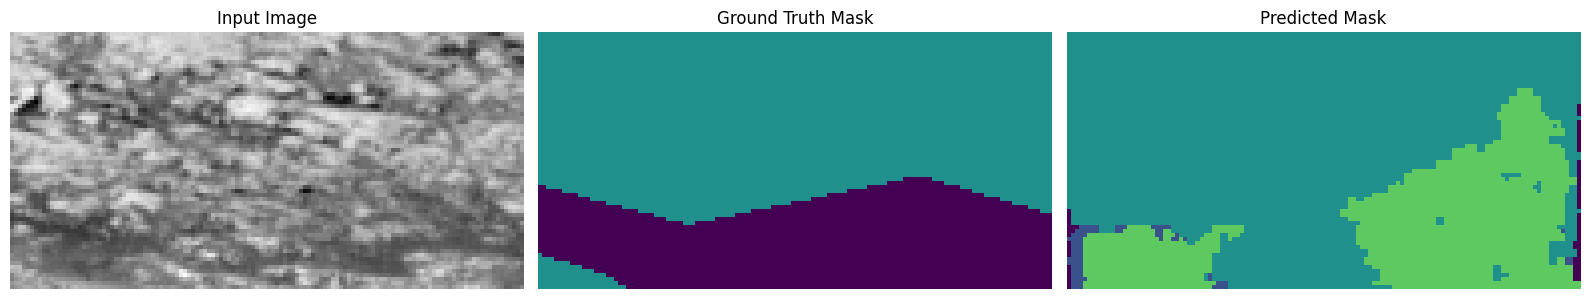

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4763 - loss: 0.5698 - val_activation_30_mean_iou: 0.4036 - val_loss: 0.7731
Epoch 127/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4812 - loss: 0.5535 - val_activation_30_mean_iou: 0.4156 - val_loss: 0.7547
Epoch 128/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4852 - loss: 0.5449 - val_activation_30_mean_iou: 0.3837 - val_loss: 0.8110
Epoch 129/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4934 - loss: 0.5191 - val_activation_30_mean_iou: 0.3959 - val_loss: 0.7951
Epoch 130/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4869 - loss: 0.5492 - val_activation_30_mean_iou: 0.3866 - val_loss: 0.7718
Epoch 131/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4764 - loss: 0.5650

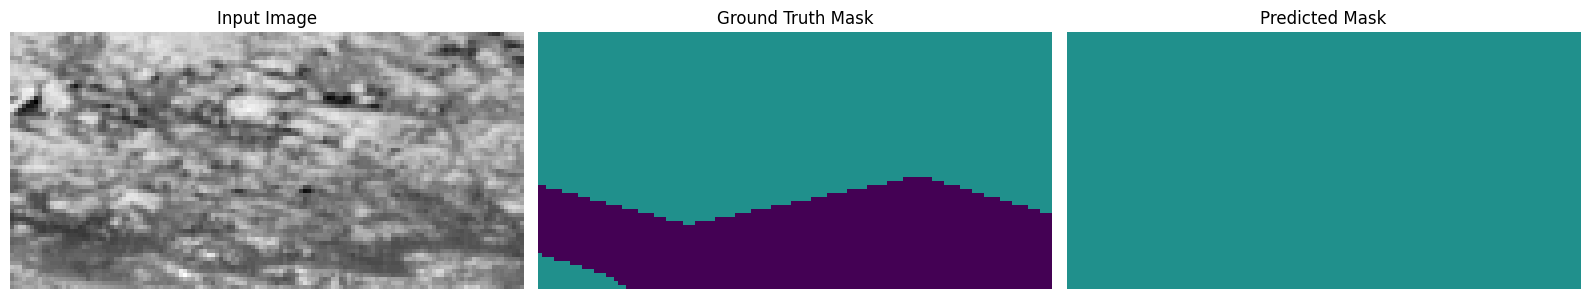

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4765 - loss: 0.5644 - val_activation_30_mean_iou: 0.3692 - val_loss: 0.9061
Epoch 132/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4770 - loss: 0.5626 - val_activation_30_mean_iou: 0.4765 - val_loss: 0.6781
Epoch 133/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4947 - loss: 0.5150 - val_activation_30_mean_iou: 0.4303 - val_loss: 0.8030
Epoch 134/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4930 - loss: 0.5176 - val_activation_30_mean_iou: 0.4550 - val_loss: 0.6406
Epoch 135/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.5002 - loss: 0.5044 - val_activation_30_mean_iou: 0.4414 - val_loss: 0.6459
Epoch 136/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4819 - loss: 0.5313

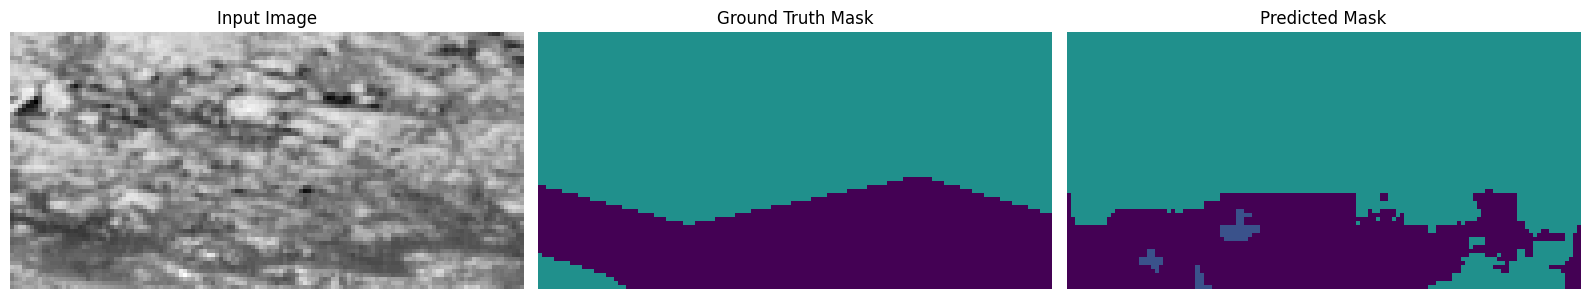

30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4821 - loss: 0.5309 - val_activation_30_mean_iou: 0.4236 - val_loss: 0.6941
Epoch 137/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4841 - loss: 0.5168 - val_activation_30_mean_iou: 0.4491 - val_loss: 0.6353
Epoch 138/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4951 - loss: 0.5151 - val_activation_30_mean_iou: 0.4742 - val_loss: 0.5816
Epoch 139/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.4936 - loss: 0.5068 - val_activation_30_mean_iou: 0.4439 - val_loss: 0.6292
Epoch 140/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4941 - loss: 0.5079 - val_activation_30_mean_iou: 0.4319 - val_loss: 0.6894
Epoch 141/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.5008 - loss: 0.4970

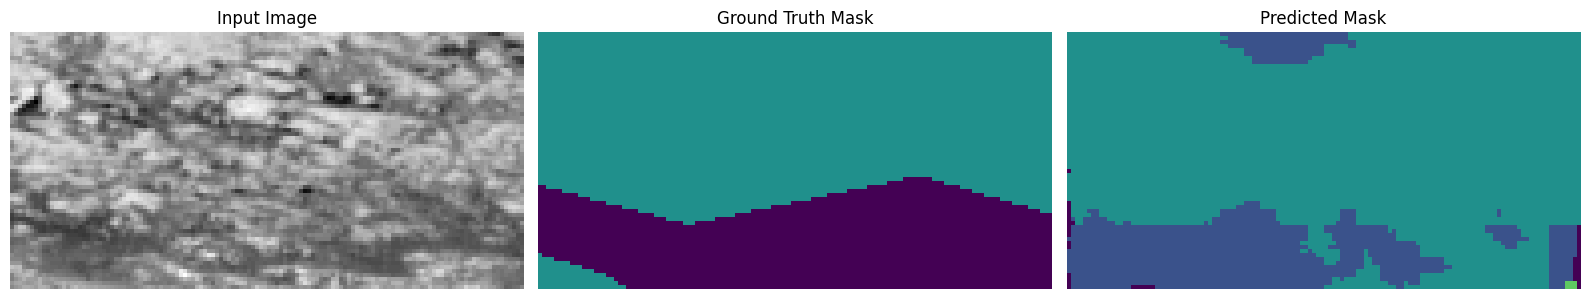

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5008 - loss: 0.4968 - val_activation_30_mean_iou: 0.4583 - val_loss: 0.6328
Epoch 142/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4920 - loss: 0.5184 - val_activation_30_mean_iou: 0.4135 - val_loss: 0.6487
Epoch 143/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4847 - loss: 0.5163 - val_activation_30_mean_iou: 0.4685 - val_loss: 0.5678
Epoch 144/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4909 - loss: 0.5097 - val_activation_30_mean_iou: 0.4571 - val_loss: 0.5973
Epoch 145/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4898 - loss: 0.5117 - val_activation_30_mean_iou: 0.4611 - val_loss: 0.6193
Epoch 146/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.4877 - loss: 0.5262

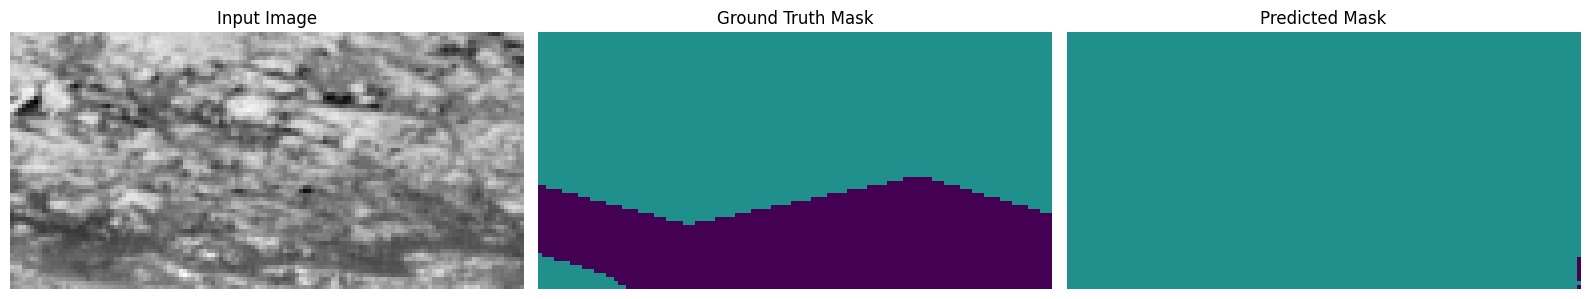

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.4878 - loss: 0.5254 - val_activation_30_mean_iou: 0.4413 - val_loss: 0.6224
Epoch 147/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4904 - loss: 0.5155 - val_activation_30_mean_iou: 0.4457 - val_loss: 0.6467
Epoch 148/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.5013 - loss: 0.4862 - val_activation_30_mean_iou: 0.4860 - val_loss: 0.6089
Epoch 149/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.4921 - loss: 0.5036 - val_activation_30_mean_iou: 0.4325 - val_loss: 0.6485
Epoch 150/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4813 - loss: 0.5159 - val_activation_30_mean_iou: 0.3841 - val_loss: 0.7949
Epoch 151/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.5056 - loss: 0.4758

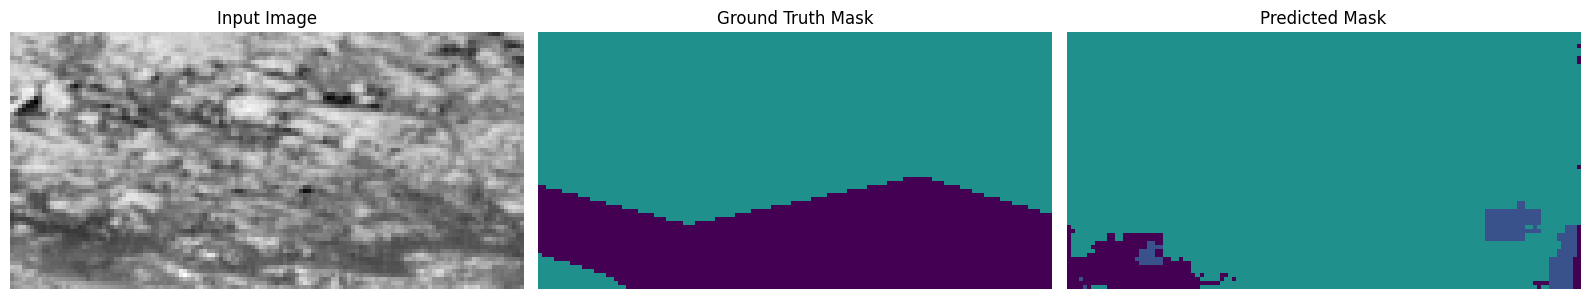

30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.5058 - loss: 0.4754 - val_activation_30_mean_iou: 0.4260 - val_loss: 0.6651
Epoch 152/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4915 - loss: 0.4919 - val_activation_30_mean_iou: 0.4440 - val_loss: 0.6012
Epoch 153/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4931 - loss: 0.5139 - val_activation_30_mean_iou: 0.4567 - val_loss: 0.5894
Epoch 154/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4979 - loss: 0.4706 - val_activation_30_mean_iou: 0.4657 - val_loss: 0.6121
Epoch 155/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.5006 - loss: 0.4718 - val_activation_30_mean_iou: 0.4638 - val_loss: 0.5617
Epoch 156/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.5164 - loss: 0.4541

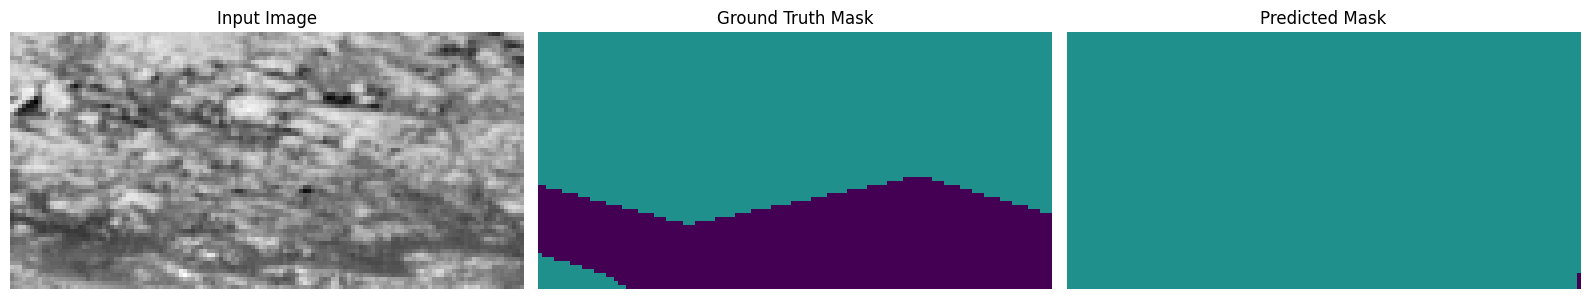

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.5160 - loss: 0.4541 - val_activation_30_mean_iou: 0.4853 - val_loss: 0.5898
Epoch 157/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - activation_30_mean_iou: 0.4969 - loss: 0.4820 - val_activation_30_mean_iou: 0.4568 - val_loss: 0.6194
Epoch 158/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.4965 - loss: 0.4750 - val_activation_30_mean_iou: 0.4377 - val_loss: 0.6386
Epoch 159/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5054 - loss: 0.4663 - val_activation_30_mean_iou: 0.4620 - val_loss: 0.6269
Epoch 160/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5186 - loss: 0.4362 - val_activation_30_mean_iou: 0.4443 - val_loss: 0.6623
Epoch 161/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.5086 - loss: 0.4610

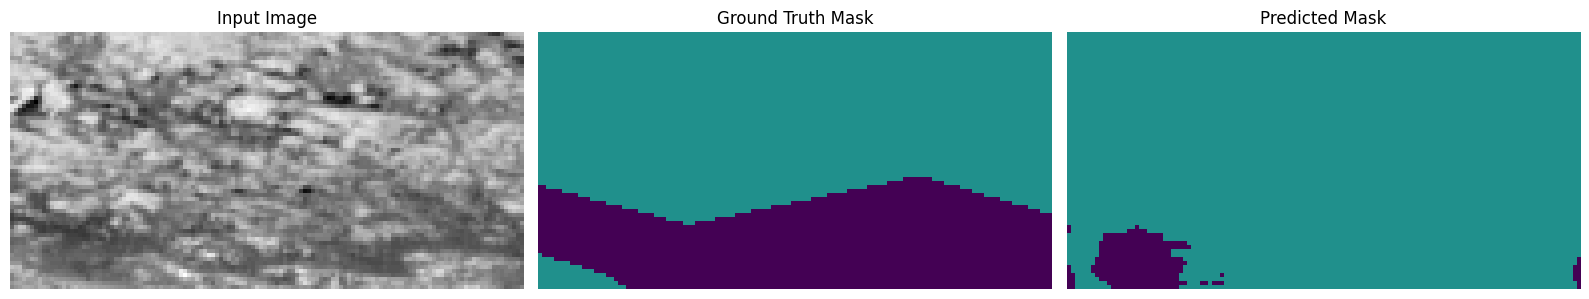

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5086 - loss: 0.4608 - val_activation_30_mean_iou: 0.4757 - val_loss: 0.5623
Epoch 162/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5051 - loss: 0.4614 - val_activation_30_mean_iou: 0.4867 - val_loss: 0.5451
Epoch 163/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5064 - loss: 0.4622 - val_activation_30_mean_iou: 0.4783 - val_loss: 0.5693
Epoch 164/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.5051 - loss: 0.4641 - val_activation_30_mean_iou: 0.4591 - val_loss: 0.5798
Epoch 165/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - activation_30_mean_iou: 0.5018 - loss: 0.4505 - val_activation_30_mean_iou: 0.4612 - val_loss: 0.6028
Epoch 166/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.5133 - loss: 0.4412

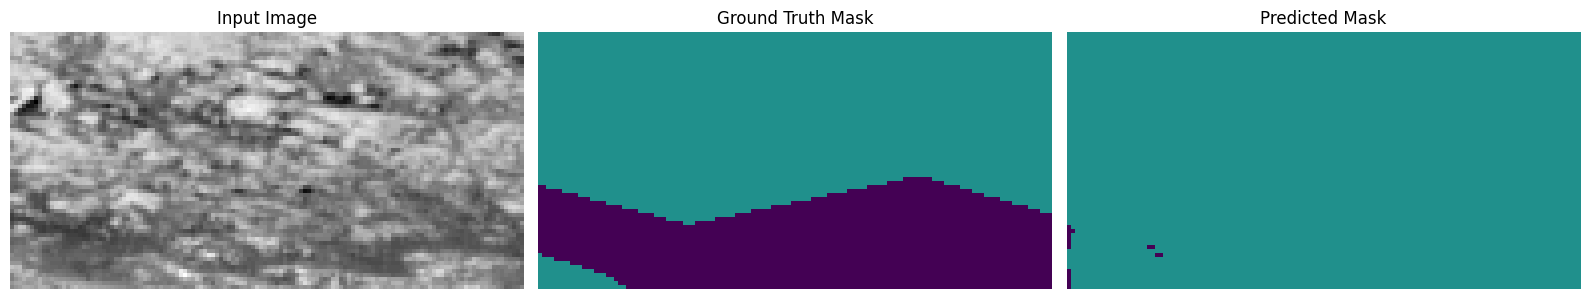

30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - activation_30_mean_iou: 0.5134 - loss: 0.4409 - val_activation_30_mean_iou: 0.4678 - val_loss: 0.5922
Epoch 167/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - activation_30_mean_iou: 0.5003 - loss: 0.4582 - val_activation_30_mean_iou: 0.4305 - val_loss: 0.6642
Epoch 168/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5040 - loss: 0.4618 - val_activation_30_mean_iou: 0.4769 - val_loss: 0.5920
Epoch 169/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5144 - loss: 0.4323 - val_activation_30_mean_iou: 0.4637 - val_loss: 0.5842
Epoch 170/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5056 - loss: 0.4490 - val_activation_30_mean_iou: 0.4651 - val_loss: 0.5874
Epoch 171/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.5242 - loss: 0.4221

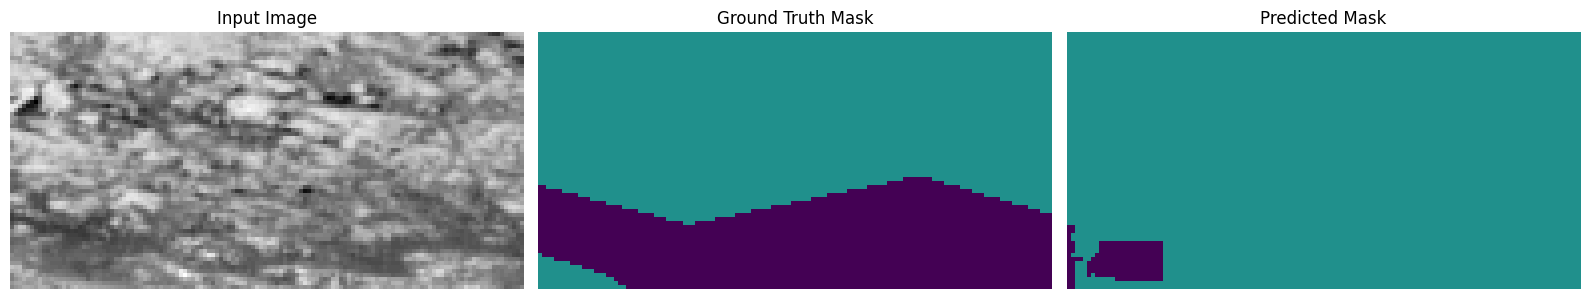

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5241 - loss: 0.4221 - val_activation_30_mean_iou: 0.4620 - val_loss: 0.6057
Epoch 172/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5122 - loss: 0.4403 - val_activation_30_mean_iou: 0.4267 - val_loss: 0.6783
Epoch 173/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5126 - loss: 0.4283 - val_activation_30_mean_iou: 0.4592 - val_loss: 0.5665
Epoch 174/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5105 - loss: 0.4217 - val_activation_30_mean_iou: 0.4157 - val_loss: 0.6537
Epoch 175/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5097 - loss: 0.4319 - val_activation_30_mean_iou: 0.4457 - val_loss: 0.6314
Epoch 176/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - activation_30_mean_iou: 0.5243 - loss: 0.4183

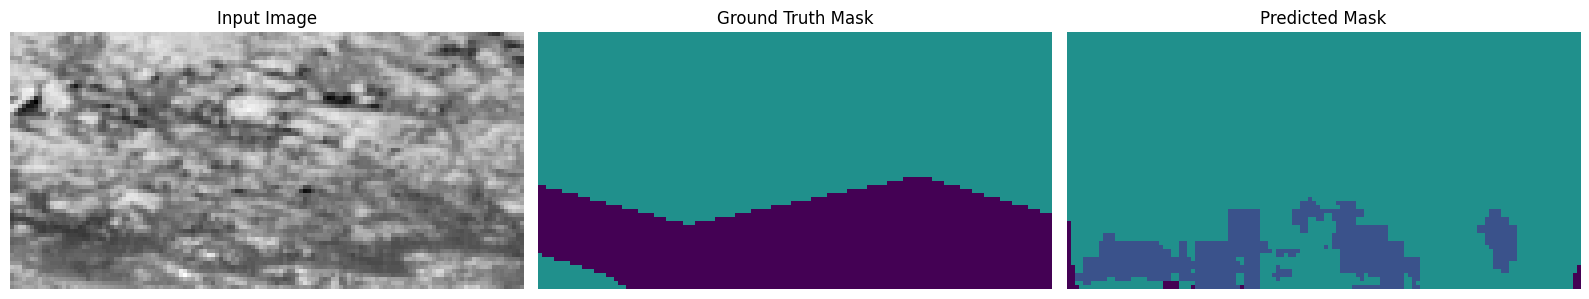

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5243 - loss: 0.4183 - val_activation_30_mean_iou: 0.3876 - val_loss: 0.7324
Epoch 177/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5132 - loss: 0.4193 - val_activation_30_mean_iou: 0.4215 - val_loss: 0.6744
Epoch 178/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5094 - loss: 0.4059 - val_activation_30_mean_iou: 0.4479 - val_loss: 0.6085
Epoch 179/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - activation_30_mean_iou: 0.5218 - loss: 0.4092 - val_activation_30_mean_iou: 0.4796 - val_loss: 0.5796
Epoch 180/500
 6/30 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - activation_30_mean_iou: 0.5251 - loss: 0.3906

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
#del model

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
#plt.figure(figsize=(18, 3))
#plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
#plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
#plt.title('Accuracy')
#plt.legend()
#plt.grid(alpha=0.3)
#plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['activation_30_mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_activation_30_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
## If model_filename is not defined, load the most recent model from Google Drive
#if "model_filename" not in globals() or model_filename is None:
#    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#    if files:
#        model_filename = files[0]
#    else:
#        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:


#start_key = 586
#end_key = 10500  # Adjust this based on the expected range
#increment = 128
#
## Function to dynamically create custom_objects
#custom_objects = {
#    f'keras_tensor_{key}': repeat_elem
#    for key in range(start_key, end_key, increment)
#}
#
#
#model = tfk.models.load_model(model_filename, compile=False, safe_mode=False, custom_objects=custom_objects)
print(f"Model loaded from {model_filename}")

In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(test_lbl[i])
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  print(preds.shape)
  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

In [ ]:
## disconnect time
from google.colab import runtime
runtime.unassign()

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```